
<h1 align=center> Image Super Resolution using Autoencoder and keras</h1>

<img src="images/high_res_v_low_res.jpg" width=550px>

## 1:  Import Libraries

In [2]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
print(tf.__version__)

2.9.0


##  2: Autoencoder?

An autoencoder is a type of artificial neural network used for unsupervised learning. It consists of two main components:

- **Encoder**: The encoder takes input data and compresses it into a lower-dimensional representation called an encoding. It learns to capture essential features from the input data.

- **Decoder**: The decoder reconstructs the original data from the encoding. It aims to produce an output that closely resembles the input.

Autoencoders are often used for various tasks, including:

- **Data Compression**: They can compress data into a compact representation, making it suitable for storage or transmission.

- **Denoising**: Autoencoders can remove noise or anomalies from data by learning to reconstruct clean data from noisy input.

- **Feature Learning**: They are used to learn meaningful representations or features from raw data, which can be useful for downstream machine learning tasks.

Autoencoders are particularly valuable for dimensionality reduction and capturing essential patterns in data, even when labeled training data is scarce.


<img src="images/autoencoder.jpg">

<h2 align="center" style="color: blue; font-size: 24px;">Encoder Architecture</h2>
<img src="images/encoder.png" width="450px" align="center">

## 3: Build the Encoder

In [3]:
input_img = Input(shape = (256,256,3))
L1 = Conv2D(64,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(input_img)

L2 = Conv2D(64,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(L1)

L3 = MaxPooling2D(padding = 'same')(L2)

L4 = Conv2D(128,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(L3)

L5 = Conv2D(128,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(L4)

L6 = MaxPooling2D(padding = 'same')(L5)

L7 = Conv2D(256,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(L6)

encoder = Model(input_img ,L7)


In [4]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     147584    
                                                             

##  4: Build the Decoder 

<img src="images/decoder.png" width=450px>

In [5]:
input_img = Input(shape = (256,256,3))
L1 = Conv2D(64,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(input_img)

L2 = Conv2D(64,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(L1)

L3 = MaxPooling2D(padding = 'same')(L2)

L4 = Conv2D(128,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(L3)

L5 = Conv2D(128,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(L4)

L6 = MaxPooling2D(padding = 'same')(L5)

L7 = Conv2D(256,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(L6)

In [6]:
L8 = UpSampling2D()(L7)

L9 = Conv2D(128,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(L8)

L10 = Conv2D(128,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(L9)

L11 = add([L5,L10])

L12 = UpSampling2D()(L11)

L13 = Conv2D(64,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(L12)

L14 = Conv2D(64,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(L13)

L15 = add([L14,L2])

decoder = Conv2D(3,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(L15)

autoencoder = Model(input_img , decoder)
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d_5[0][0]']               
                                )                                                           

In [7]:
autoencoder.compile(optimizer = 'adadelta', loss = 'mean_squared_error')

##  5: Dataset 

In [8]:
def train_batches(just_load_dataset=False):

    batches = 32

    batch = 0 
    batch_nb = 0 
    max_batches = -1 
    
    ep = 4 

    images = []
    x_train_n = []
    x_train_down = []
    
    x_train_n2 = [] 
    x_train_down2 = []
    
    for root, dirnames, filenames in os.walk("data/cars_train"):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: 
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                        
                    image_resized = resize(image, (256, 256))
                    x_train_n.append(image_resized)
                    x_train_down.append(rescale(rescale(image_resized, 0.5), 2.0))
                    batch += 1
                    if batch == batches:
                        batch_nb += 1

                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)
                        
                        if just_load_dataset:
                            return x_train_n2, x_train_down2
                        
                        print('Training batch', batch_nb, '(', batches, ')')

                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)
                    
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0

    return x_train_n2, x_train_down2

##  6: Load the Dataset and Pre-trained Model

In [9]:
x_train_n , x_train_down = train_batches(just_load_dataset = True)

In [10]:
autoencoder.load_weights('data/sr.img_net.mse.final_model5.no_patch.weights.best.hdf5')

##  7: Model Predictions and Visualizing the Results

In [11]:
encoder.load_weights('data/encoder_weights.hdf5')

In [12]:
print(x_train_n.shape)
print(x_train_down.shape)
x_train_down = x_train_down[:, :, :, :3]  # Keep only the first three channels (RGB)

(32, 256, 256, 3)
(32, 256, 256, 4)


In [13]:
encoded_imgs = encoder.predict(x_train_down)

1/1 [==============================] - 4s 4s/step


In [14]:
encoded_imgs.shape

(32, 64, 64, 256)

In [15]:
batch_size = 32
num_samples = len(x_train_down)

sup_res1 = []
for i in range(0, num_samples, batch_size):
    batch_predictions = autoencoder.predict(x_train_down[i:i+batch_size])
    sup_res1.append(np.clip(batch_predictions, 0.0, 1.0))

sup_res1 = np.vstack(sup_res1)

1/1 [==============================] - 15s 15s/step


In [54]:
image_index = np.random.randint(0,32)

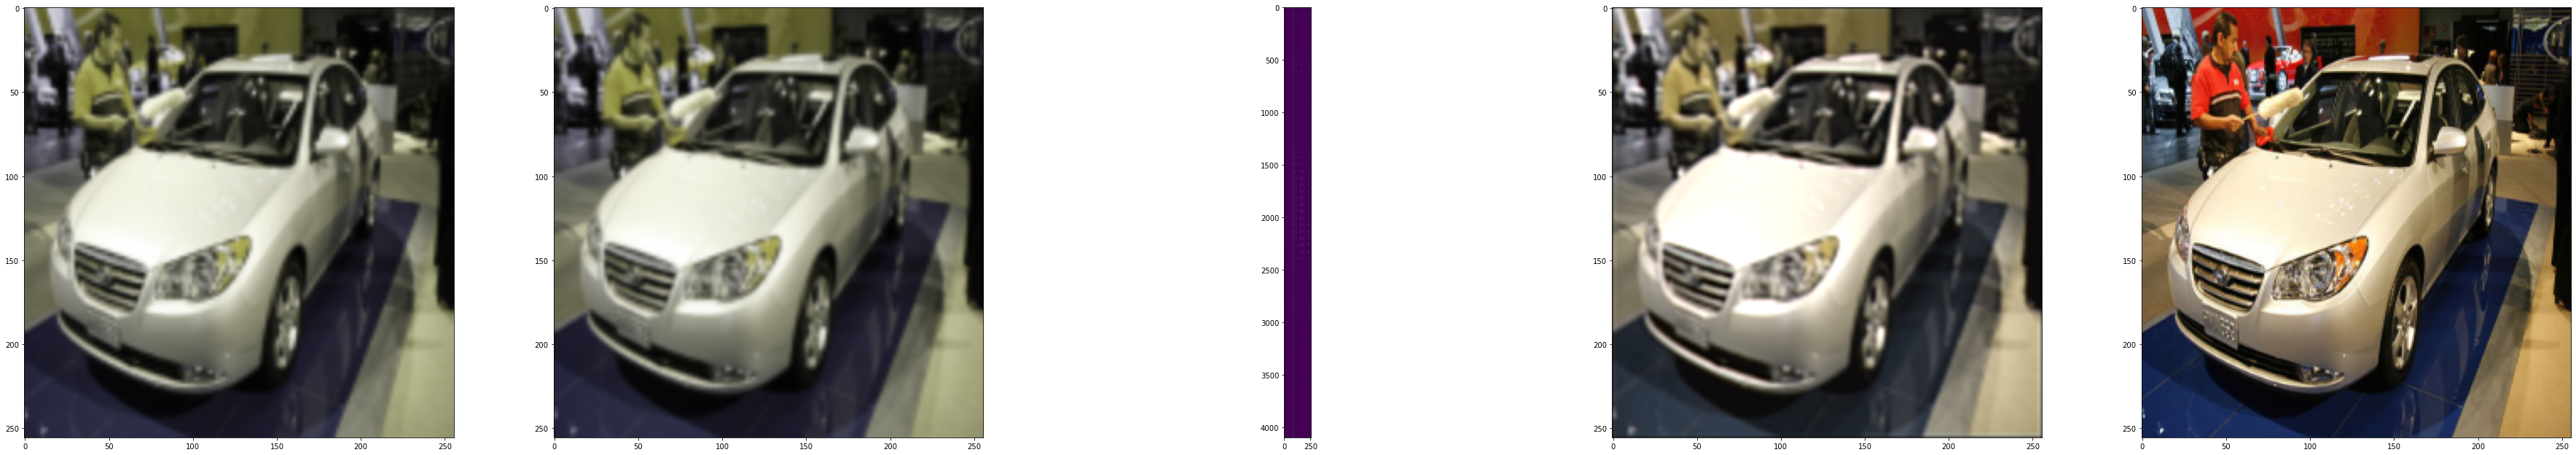

In [55]:
plt.figure(figsize=(128,128))
i = 1
ax = plt.subplot(10,10,i)
plt.imshow(x_train_down[image_index])
i += 1
ax = plt.subplot(10,10,i)
plt.imshow(x_train_down[image_index], interpolation='bicubic')
i += 1
ax = plt.subplot(10,10,i)
plt.imshow(encoded_imgs[image_index].reshape((64*64,256)))
i += 1
ax = plt.subplot(10,10,i)
plt.imshow(sup_res1[image_index])
i += 1
ax = plt.subplot(10,10,i)
plt.imshow(x_train_n[image_index])
plt.show()